#Executive Summary

## Looking at the problem, it appears to be a classic image classification problem. 

##However, the number of classes (101) and the size of the database (1000 images per class) add some complexity (Total 101,000 images)

##At the outset, it may seem like a straightforward application of the Vision Module in Fast AI using get_transforms augmentation should suffice.

##However, on deeper analysis, one realises the need for custom augmentations, which bring the challenge of training time and accuracy in the picture. 

##This challenge also highlights the powerful features of Fast.AI compared to Keras, TensorFlow or even basic Pytorch

##Further the selection of model architecture becomes very important in this case due to size and complexity of the database. We cannot use the simpler one like Resnet_18 or Resnet_34 to deep capacity to learn this dataset.

##Other architectures like Inception or Densenet would be too heavy and an overkill.  

##The highest level achieved for this particular problem which I could find is 89.58  

##A human observation of the images in the dataset reveals that the subject in the images are clear and fitted well in each frame with minimal noise or distortion or magnification. 

##We will look to leverage the tools in Fast.AI like
##ClassificationInterpretation class which provides a confusion matrix and visualization of the most incorrect images. 

##We will be using Imagenet to mormalize this dataset.

##Libraries used:
https://docs.fast.ai/
https://pytorch.org/

##The Vision module with the CNN learner will be used to implement Transfer Learning for this database

##We can improve the results by doing a special augmentation of the misclassifed classes.
##Secondly we can increase the frequency of the misclassified classes by writing some functions to increase the images in these classes so the model has an opportunity to learn these classes in depth.

##This is an exciting exercise because we can dive deep into fine tuning the augmentations with a potential to arrive at an fairly accurate model which has several real world applications and through Transfer Learning, can be used in areas such as ecommerce, travel, food and many such industries

##Dataset:
https://www.vision.ee.ethz.ch/datasets_extra/food-101/

# Check GPU

In [ ]:
!nvidia-smi

Sun Jul 19 06:52:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downgrade pytorch version and restart runtime

Load pytorch v1.4 to overcome Fast.ai compatibility error with v1*.5*

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 33.9MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


# Import Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
# used during model training to save the model, change learning rate, reduce lr
from fastai.callbacks.hooks import *


In [ ]:
torch.__version__

'1.4.0'

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing

Get Dataset once and load in Gdrive

In [ ]:
# Downloading the dataset from the website
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2020-07-18 15:52:03--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-07-18 15:52:03--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  12.6MB/s    in 7m 1s   

2020-07-18 15:59:04 (11.3 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
# Unzipping the dataset into Google Drive Storage
# !tar xzvf '/content/drive/My Drive/Colab Notebooks/food-101/food-101.tar.gz' -C '/content/drive/My Drive/Colab Notebooks/food-101/'

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/food-101/food-101')
path_img = path/'images'

# Image Augmentation

We leverage Fast.ai features to add the paths and .jpg file extensions to the files in the directories and ingest the data into the Pandas Dataframe 

Total images 101K
Uniform distribution of images across classes.
80/20 split training /validation

Initially we resize the images to 224x224 to improve training time

We will then train with original size of 512x512 for a few epochs for our final results


Data augmentation during training uses the set of transforms provided by the Fast AI Vision library by using the RandTransform method with custom screening of the parameters and transform options.

I have played with the augmentations by changing parameters, probabilites and making informed changes as per the docs.fastai wiki, saving the transforms and re-running to see the impact on accuracy as well as run-time

Read and Organize Data, Augment image data and Create Databunch

---



In [ ]:
train_path = path/'meta/train.txt'
test_path = path/'meta/test.txt'

# function to convert csv file to dataframe
def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

# use fastai to write the transformation/augmentation function
# tried using RandTransform to exercise more control than get_transforms and play with the various augmentation modules
# for this dataset, I think adding cutout, jitter would help improve accuracy, albeit increasing the training time significantly.
# Studied the documentation for the vision modules and the various classes and played with several options.
data_tfms = ([RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.5, resolved={}, do_run=True, is_random=True), 
            # RandTransform(tfm=TfmCoord (perspective_warp), kwargs={'magnitude': (-0.01, 0.01)}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmPixel (cutout), kwargs={}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            # RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True)],
            RandTransform(tfm=TfmPixel (crop), kwargs={'size':224, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True)],
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

bs = 128
# read the list of train/test image names from the dataframe and provide the path to the images itself
# create Databunch with image size 224, use 80/20 split for training/validation
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(data_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


# Data Visualization (Sanity Check)

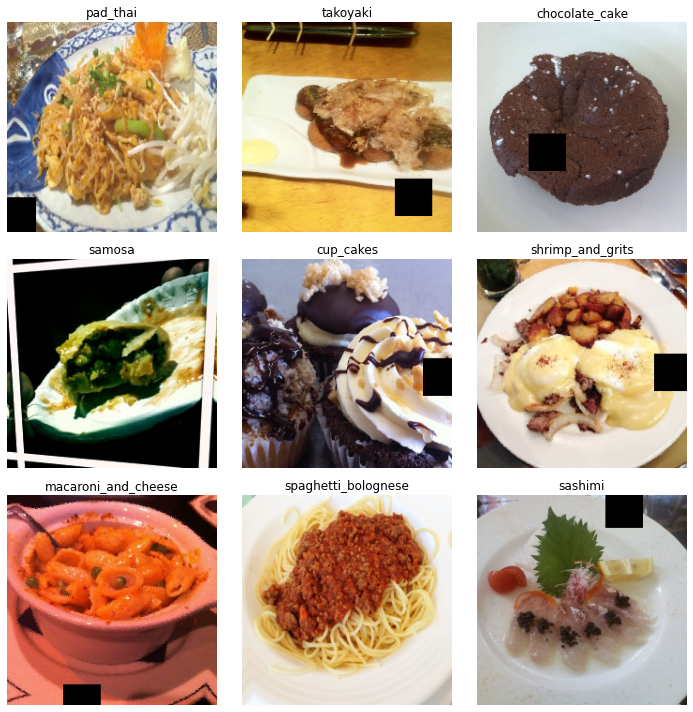

In [ ]:
data.show_batch(rows=3, figsize=(10, 10))

In [ ]:
print(data.classes);
print(data.c)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

# Model Compilation

(top-1)accuracy (noted as top_k_accuracy) and the top-5 accuracy. ResNet_50 architecture model used![alt text](https://)

In [ ]:
arch = models.resnet50
top_5 = partial(top_k_accuracy, k=5)

learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)

# LR finder

### Learning rate is critical.
LR >> Validation Loss too High
LR << Error Rate improves slowly, long time to train (refit) 
Epochs >> Overfit, ER too high
Epochs << Training Loss more than Validation Loss, ER improves (refit)
We use the fastai learning rate finder to glean a good starting point for a learning rate. Consider the point where the loss just begins to taper (slope)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 6.92E-03


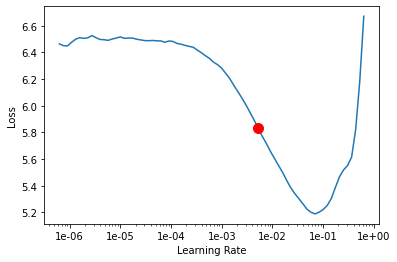

In [ ]:
learn.recorder.plot(suggestion=True)


### Use Learning Rate based on LR Finder results

# Model Training 224x224

### Run Epochs

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.158015,1.713760,0.560924,0.817228,17:25
1,1.697870,1.387138,0.635116,0.869901,17:19
2,1.428176,1.212036,0.680396,0.892013,17:20
3,1.226498,1.116558,0.706931,0.905611,17:24
4,1.103423,1.088493,0.712145,0.908515,17:13


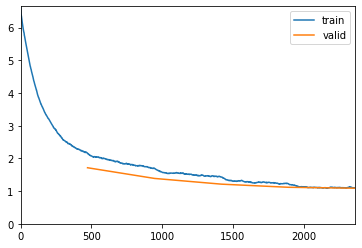

In [ ]:
lr = 5.25E-03
learn.fit_one_cycle(5, slice(lr))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e5')

### Run all layers of Resnet_50

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-06


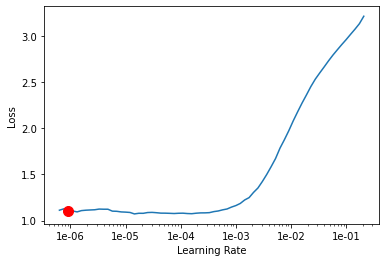

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.119090,1.062779,0.717888,0.911749,17:36
1,1.047927,0.981762,0.738152,0.920792,17:37
2,0.816860,0.874968,0.766799,0.929967,17:38
3,0.562686,0.808358,0.788977,0.938944,17:44
4,0.459998,0.793222,0.793531,0.940132,17:50


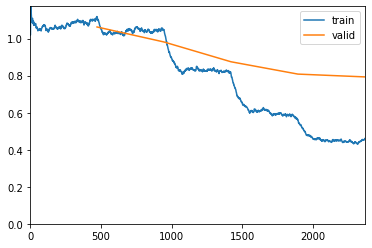

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e10')

# Model Training 512x512

### As per Jeremy, first train with 224x224
### Now switch to 512x512 to increase the accuracy

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


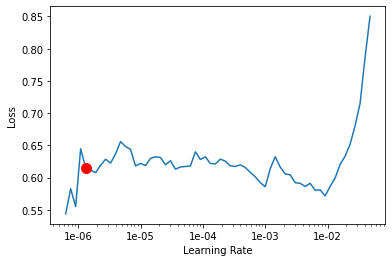

In [ ]:
bs=16
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(data_tfms, size=512)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e10')

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.043992,1.940928,0.819076,0.954191,39:17
1,1.112352,13.623695,0.767591,0.923894,39:38
2,0.887344,8.390129,0.810033,0.939736,39:14


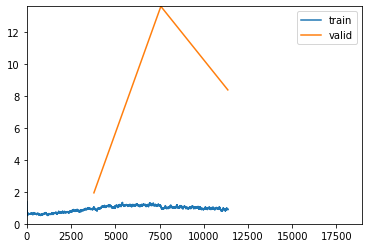

Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-2))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e15-512')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.982604,4.397979,0.814521,0.950297,47:39
1,1.197358,18.767660,0.784885,0.930957,47:01
2,0.876848,5.836538,0.816832,0.948515,46:33
3,0.535852,7.380018,0.850297,0.958416,46:18
4,0.421285,0.594906,0.867327,0.970099,46:06


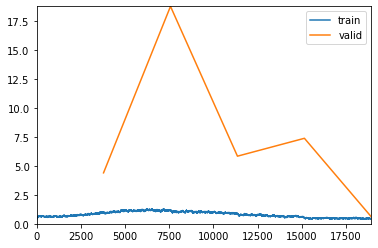

In [ ]:
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e15-512')
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-2))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e20-512')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.969176,2.414239,0.831749,0.954719,48:32
1,0.566800,2.786141,0.888713,0.973201,47:55


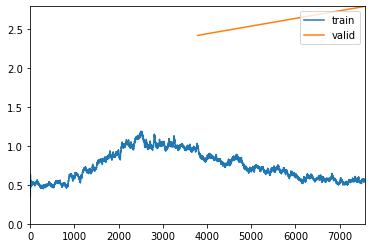

In [ ]:
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e20-512')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7, 1e-2))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e22-512')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.882530,7.375915,0.808185,0.932541,48:31
1,0.478400,8.323640,0.884092,0.963432,48:30


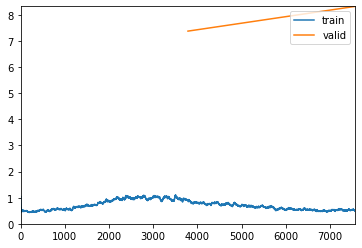

In [ ]:
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e22-512')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7, 1e-2))
learn.save('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e24-512')

# Model Evaluation

We are now going to evaluate the model on 20% of the training data set. We are going to use FAST.AI built in functions like top losses and confusion matrix.
We load our model which we ran for 24 Epochs. 

In [ ]:
bs=16
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(size=512)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('/content/drive/My Drive/Colab Notebooks/food-101/food-101-e24-512')

Learner(data=ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
paella,pancakes,chicken_quesadilla,chicken_wings,ravioli
Path: data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d

Now we are using ClassificationInterpretation which is a class in fast.ai to evaluate our results. 


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

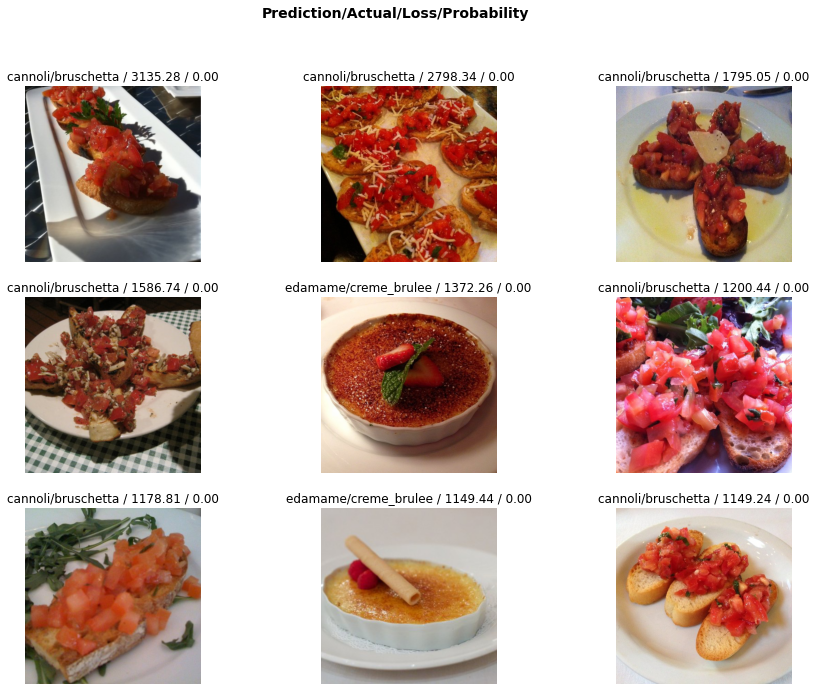

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

### Looking at the results, it appears the model is having difficulty differentiating Cannoli. Empirically looking at the results above, perhaps using the rgb_randomize transform of the TfmPixel class in the vision module would help improve the results. The idea would be to get the model to focus on the shape and texture rather than the color, which it appears to be doing currently.



In [ ]:
interp.most_confused(min_val=5)

[('prime_rib', 'steak', 19),
 ('steak', 'filet_mignon', 19),
 ('bruschetta', 'cannoli', 17),
 ('filet_mignon', 'steak', 17),
 ('chocolate_mousse', 'chocolate_cake', 14),
 ('beef_tartare', 'tuna_tartare', 12),
 ('creme_brulee', 'edamame', 12),
 ('chocolate_cake', 'chocolate_mousse', 10),
 ('pork_chop', 'steak', 9),
 ('bread_pudding', 'apple_pie', 8),
 ('miso_soup', 'cheesecake', 8),
 ('carrot_cake', 'chocolate_cake', 7),
 ('dumplings', 'gyoza', 7),
 ('gyoza', 'dumplings', 7),
 ('ramen', 'pho', 7),
 ('sushi', 'sashimi', 7),
 ('mussels', 'cheesecake', 6),
 ('sashimi', 'sushi', 6),
 ('steak', 'prime_rib', 6),
 ('tuna_tartare', 'ceviche', 6),
 ('apple_pie', 'bread_pudding', 5),
 ('caprese_salad', 'greek_salad', 5),
 ('clam_chowder', 'lobster_bisque', 5),
 ('croque_madame', 'grilled_cheese_sandwich', 5),
 ('donuts', 'beignets', 5),
 ('foie_gras', 'beet_salad', 5),
 ('hummus', 'chicken_quesadilla', 5),
 ('ice_cream', 'frozen_yogurt', 5),
 ('miso_soup', 'macarons', 5),
 ('spring_rolls', 'break

Looking at above it appears, Prime Rib is being confused for Steak, which is a real world sense is similar and would be acceptable. Infact the top 10 mis-labeled classes identified above are very similar and susceptible to human error also. 
However,('miso_soup', 'cheesecake', 8) are expected to be distinct. Also  ('mussels', 'cheesecake', 6) is also mis-classified. So it gives me some direction to look into.

I would study the images in these categories to glean some relevant information and apply more augmentations accordingly, perhaps augment based on shape or zoom into the images so we normalize the effect of shape would help in this case.


In [ ]:
# Exceeding RAM in Google Colab
# This would help identify any mis-labeled images, unfortunately it was not able to run due to memory limits.
interp.plot_multi_top_losses()

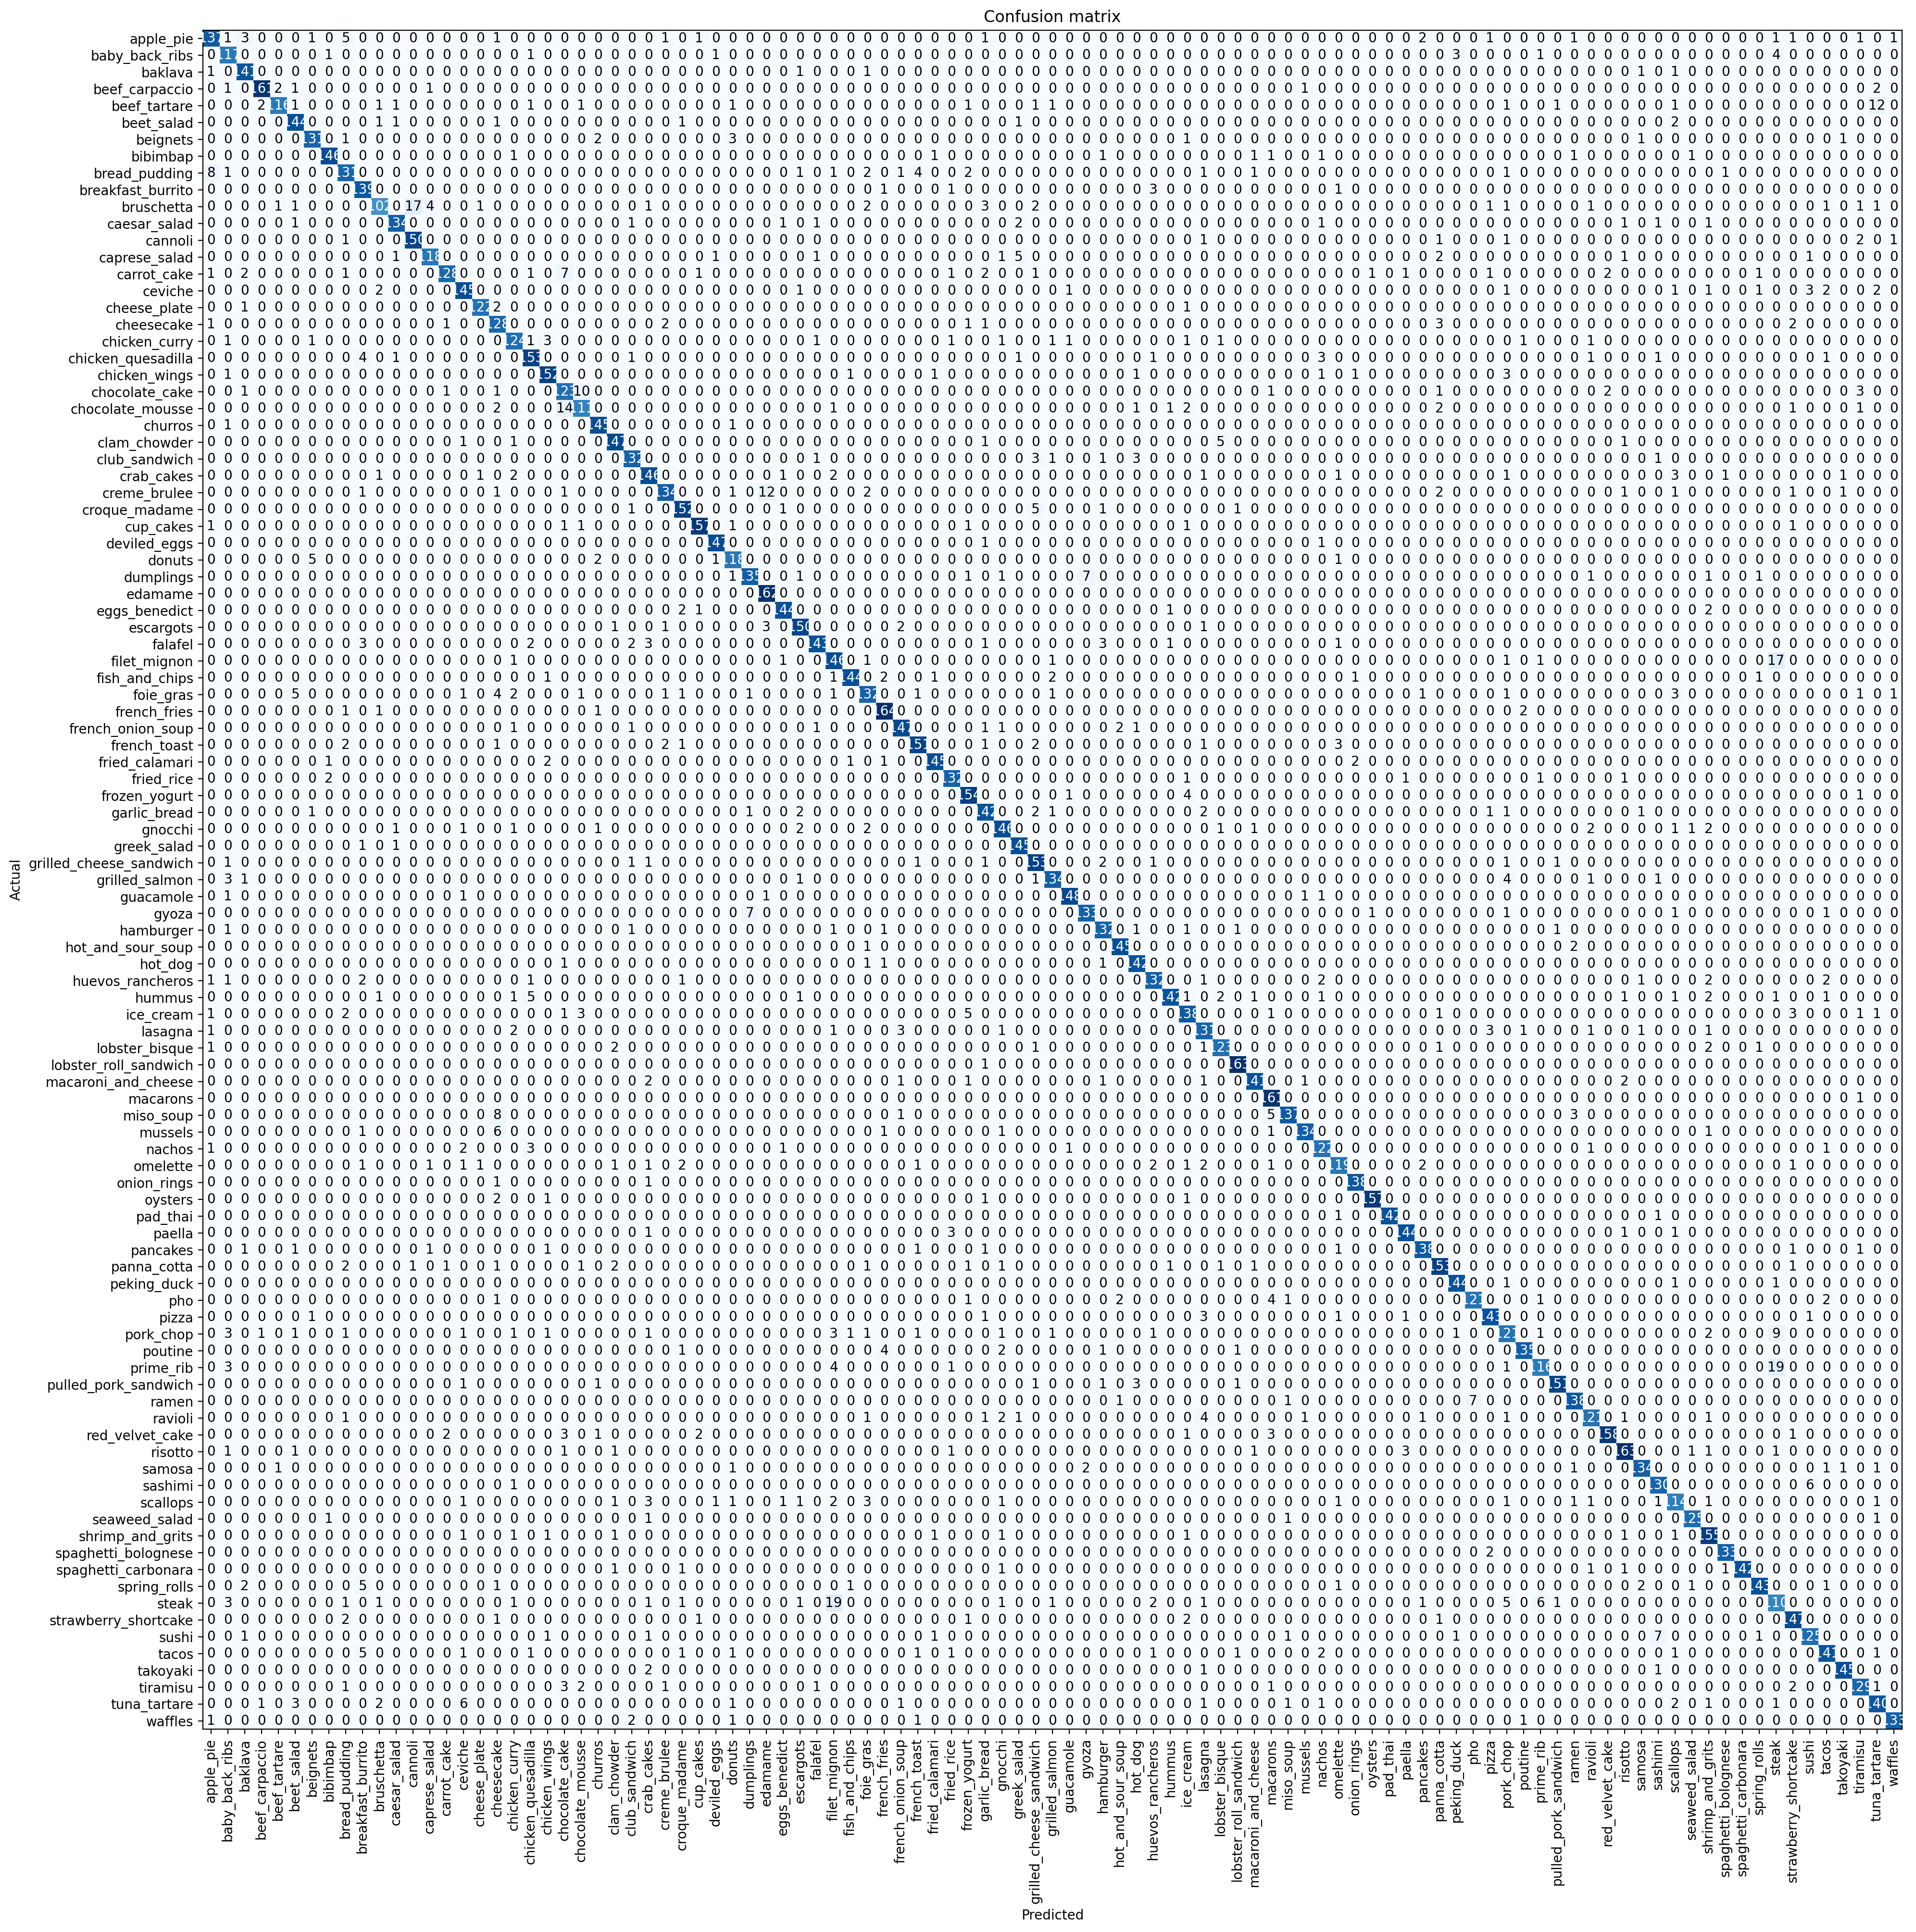

In [ ]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=200)

# Test Set Predictions

Now running the model to predict and verify the Accuracy of the model

(Category tensor(93), tensor(93), tensor([2.8669e-07, 1.2616e-01, 2.0019e-06, 4.3872e-05, 1.1423e-05, 7.2516e-06,
        1.4489e-05, 4.3856e-06, 3.7358e-06, 1.2728e-05, 4.1171e-05, 6.7702e-06,
        4.1797e-07, 1.7600e-05, 6.7425e-07, 7.7887e-06, 1.2645e-05, 6.5912e-07,
        3.1005e-05, 1.8627e-05, 2.7576e-05, 4.0365e-06, 4.5708e-07, 9.7650e-05,
        2.1756e-06, 2.7482e-04, 1.4400e-06, 1.3446e-06, 3.3836e-05, 1.5355e-06,
        8.5818e-07, 2.6090e-05, 1.5215e-04, 8.2385e-07, 1.9089e-05, 2.1861e-05,
        1.0438e-05, 3.6346e-03, 1.9375e-06, 5.4998e-06, 4.1856e-06, 4.0576e-06,
        2.7799e-04, 1.4372e-06, 1.1565e-06, 7.8193e-07, 6.2869e-06, 4.7637e-06,
        3.1718e-05, 3.6855e-05, 1.2687e-04, 9.9688e-07, 5.1684e-06, 2.0016e-03,
        2.7860e-06, 5.9017e-05, 1.6939e-05, 4.2542e-06, 1.3198e-06, 6.7755e-06,
        1.9266e-06, 9.9174e-05, 1.7336e-06, 1.5827e-06, 2.8571e-07, 2.8971e-06,
        6.8881e-07, 6.5439e-05, 2.9709e-06, 3.9710e-05, 4.0591e-07, 2.5518e-06,
      

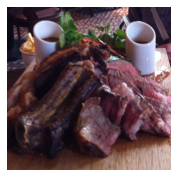

In [ ]:
img = open_image('data/food-101/images/prime_rib/1001089.jpg')
img.show()
print(learn.predict(img))
print(test_data.classes[79])

(Category tensor(93), tensor(93), tensor([1.4998e-04, 2.8315e-02, 1.7017e-03, 2.7886e-04, 9.6029e-04, 3.2703e-04,
        7.2835e-05, 8.2650e-04, 1.4054e-03, 7.4317e-04, 1.8704e-04, 7.3534e-06,
        1.7956e-05, 1.9357e-05, 2.2251e-04, 4.4989e-05, 8.8457e-04, 3.7835e-05,
        1.7609e-03, 7.1173e-05, 3.4049e-03, 4.3666e-04, 2.4063e-04, 8.2114e-05,
        2.6715e-04, 3.1500e-05, 2.0592e-03, 2.1075e-05, 3.3022e-05, 1.5532e-04,
        8.1419e-03, 3.9451e-04, 2.7543e-03, 1.4067e-05, 1.8664e-04, 1.1666e-02,
        3.7468e-04, 3.0940e-01, 9.6485e-04, 2.8838e-04, 6.3980e-05, 2.0840e-05,
        7.2162e-05, 6.7241e-03, 1.5939e-04, 4.3714e-06, 1.4756e-04, 1.0362e-03,
        2.1452e-05, 1.5613e-05, 1.5597e-03, 6.5404e-04, 6.4228e-05, 2.1597e-03,
        2.7884e-05, 1.4838e-04, 8.2706e-04, 4.1340e-03, 1.5572e-04, 3.0236e-04,
        2.3678e-05, 1.0086e-05, 7.1545e-03, 1.0095e-05, 9.8164e-06, 9.9378e-04,
        4.7490e-05, 1.2921e-03, 6.7493e-04, 2.3342e-03, 9.2432e-05, 3.2715e-03,
      

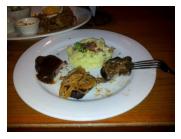

In [ ]:
img = open_image('data/food-101/images/steak/1000205.jpg')
img.show()
print(learn.predict(img))
print(test_data.classes[93])

(Category tensor(17), tensor(17), tensor([3.2727e-04, 2.1832e-06, 2.8982e-07, 1.0452e-08, 1.2390e-06, 7.0396e-07,
        1.5392e-06, 5.0939e-08, 1.1411e-03, 1.1989e-06, 1.9377e-06, 5.2767e-07,
        1.3478e-06, 1.5023e-07, 1.0880e-02, 4.7230e-07, 3.8695e-05, 9.7640e-01,
        1.1749e-05, 2.9384e-07, 4.6436e-06, 3.9295e-05, 3.5468e-05, 1.3432e-06,
        2.6718e-07, 1.1900e-05, 5.7222e-07, 3.8687e-06, 9.3235e-08, 2.7989e-06,
        2.7572e-07, 1.3818e-06, 2.1851e-08, 9.8477e-08, 1.5874e-08, 9.4451e-07,
        1.6284e-07, 5.8745e-08, 5.4889e-06, 9.5775e-07, 6.2353e-08, 4.0135e-08,
        2.4504e-06, 8.2317e-06, 1.9514e-06, 2.4912e-07, 4.6692e-06, 6.8507e-07,
        4.7129e-07, 6.8432e-07, 6.6775e-08, 1.3499e-07, 2.3848e-10, 3.0842e-08,
        3.6252e-08, 1.4250e-07, 2.1041e-06, 1.2353e-03, 1.1717e-05, 1.6862e-06,
        1.1950e-06, 1.5653e-06, 3.4380e-06, 4.3774e-07, 2.6131e-07, 3.2734e-07,
        1.3609e-06, 4.3433e-06, 3.8830e-07, 7.8804e-08, 3.5304e-07, 3.5765e-07,
      

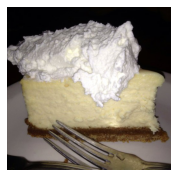

In [ ]:
img = open_image('data/food-101/images/cheesecake/3920168.jpg')
img.show()
print(learn.predict(img))
print(test_data.classes[17])

(Category tensor(64), tensor(64), tensor([1.3798e-08, 4.1833e-10, 1.7012e-08, 7.6229e-09, 8.3904e-09, 6.0536e-08,
        9.6890e-09, 3.5578e-08, 2.7597e-08, 1.2938e-08, 3.2802e-07, 1.3080e-08,
        5.2489e-07, 3.4221e-07, 1.5769e-09, 1.8039e-10, 1.2563e-09, 1.3689e-08,
        4.9596e-08, 4.3706e-07, 1.2340e-09, 2.1937e-10, 7.0251e-09, 1.8119e-09,
        1.0843e-06, 4.0342e-10, 1.8025e-09, 9.4825e-08, 1.1683e-10, 5.3897e-08,
        3.5142e-08, 9.6594e-09, 6.9661e-08, 2.4800e-07, 3.8877e-10, 1.9886e-05,
        6.9178e-07, 5.4673e-08, 9.0241e-10, 1.0783e-07, 2.1112e-07, 1.8712e-07,
        1.1218e-08, 1.1211e-07, 1.7348e-09, 1.8849e-07, 5.5818e-06, 6.3593e-08,
        3.8011e-08, 4.8374e-09, 1.3616e-08, 7.6093e-07, 2.4918e-07, 6.5501e-09,
        1.7780e-07, 2.1047e-08, 1.1463e-09, 6.5620e-07, 6.9705e-08, 3.3666e-09,
        3.3376e-07, 2.0245e-10, 2.5324e-08, 2.8340e-08, 9.9996e-01, 6.8870e-07,
        4.5868e-08, 1.0766e-09, 1.8144e-08, 9.6313e-09, 2.0597e-11, 2.2204e-09,
      

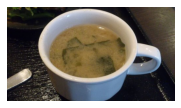

In [ ]:
img = open_image('data/food-101/images/miso_soup/3924511.jpg')
img.show()
print(learn.predict(img))
print(test_data.classes[64])

(Category tensor(65), tensor(65), tensor([4.6086e-11, 2.7016e-10, 1.6336e-12, 1.3260e-09, 1.9079e-07, 4.8200e-10,
        4.3299e-09, 9.8771e-10, 9.8993e-11, 2.0801e-09, 2.1347e-09, 1.9220e-11,
        2.3635e-07, 2.4615e-10, 3.3621e-11, 9.8040e-09, 5.4991e-11, 8.8811e-10,
        1.0700e-08, 5.7787e-09, 4.6382e-09, 5.4933e-11, 3.7666e-10, 1.5206e-11,
        1.8915e-07, 1.2751e-10, 1.0481e-07, 1.0077e-09, 8.4574e-10, 7.6549e-10,
        2.5864e-10, 3.2347e-11, 2.4666e-11, 2.2408e-08, 5.3632e-11, 1.1578e-08,
        5.1370e-09, 1.4003e-10, 2.2420e-07, 1.1570e-07, 3.3590e-09, 5.1291e-10,
        2.6653e-09, 5.7468e-10, 3.8350e-09, 1.3753e-09, 2.1465e-09, 1.2330e-08,
        2.8455e-10, 1.5397e-08, 4.1275e-06, 4.6604e-08, 1.9197e-10, 1.1064e-10,
        2.7160e-10, 4.3963e-10, 8.1493e-09, 3.4805e-08, 4.1179e-11, 1.5952e-09,
        1.2831e-08, 1.2025e-10, 4.4382e-08, 8.1727e-09, 2.5464e-08, 9.9334e-01,
        3.4711e-09, 1.8455e-10, 3.7987e-11, 5.7712e-07, 1.2777e-08, 6.6540e-03,
      

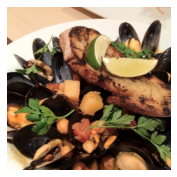

In [ ]:
img = open_image('data/food-101/images/mussels/1009170.jpg')
img.show()
print(learn.predict(img))
print(test_data.classes[65])

# Final Result

In [ ]:
learn.validate(test_data.train_dl)

[3.7210763, tensor(0.8697), tensor(0.9691)]

## Top 1 - 86.97%
## Top 5 - 96.91%

# Analysis


Looking at above it appears, Prime Rib is being confused for Steak, which is a real world sense is similar and would be acceptable. Infact the top 10 mis-labeled classes identified above are very similar and susceptible to human error also. 
However,('miso_soup', 'cheesecake', 8) are expected to be distinct. Also  ('mussels', 'cheesecake', 6) is also mis-classified. So it gives me some direction to look into.

I have displayed the images in these categories to glean some relevant information and apply more augmentations accordingly, perhaps augment based on shape or zoom the images so we reduce the effect of shape, which could help in this case.

I am also predicting the mis-classified categories as a sample.

In the companion scratch file I have played with several augmentations including jitter, cutout, warp, crop, brightness and lightning during training time captured the impact on accuracy and run time.


